# Playing with images
This notebook is sandbox of my attemps what is way to concat **read partially** images. 

After I get list of required images for concatination I need to find:
-  [X] Deal with simple way how to cut in one image (no overlapping with other nearest 1x1 km images) 
-  [X] The way how is efficient to read images partially (Which image's edge should I cut? Left-top, right-bottom etc? How?).
-  [X] If i have time deal with no found case, black image as well (in case of no available images).

Wasn't implemented
-  [ ] Partially generated image with black tiles (not all tiles are found, so i need to paste black tiles next to it)/

In [1]:
# Imports
import logging

import matplotlib.pyplot as plt
import rasterio
from rasterio.windows import from_bounds
import pathlib
from pathlib import Path
from PIL import Image
import numpy as np
import re
from typing import List, Tuple
import copy
from functools import lru_cache
from pyproj import Transformer

# Typing
Latitude = float
Longitude = float

LatitudeLeft = float
LongitudeBottom = float
LatitudeRight = float
LatitudeTop = float

In [2]:
logging.basicConfig(format="[%(asctime)s] [%(levelname)s] %(message)s", level=logging.INFO)
log = logging.getLogger(__name__)

In [3]:
# Please change it according your dataset path
DATASET_DIRECTORY = (
    "/Users/ksafiullin/src/geospatial_data_processing/data/orthophotos/nw"
)

In [4]:
# utils functions

TransformerFromCRS = lru_cache(Transformer.from_crs)

def get_bounding_box(
    image_filepath: pathlib.Path,
) -> Tuple[LatitudeLeft, LongitudeBottom, LatitudeRight, LatitudeTop]:
    """Return 1000x1000 meters bounding box"""
    pattern = r"dop10rgbi_32_(\d+)_(\d+)_1_nw_\d{4}\.jp2"
    match = re.match(pattern, image_filepath.name)
    if not match:
        raise ValueError(
            f"Incorrect filepath. Got {image_filepath}," "expected 'dop10rgbi_32_<easting>_<northing>_1_nw_<year>.jp2'"
        )

    latitude_left = int(match.group(1)) * 1000
    latitude_right = latitude_left + 999
    longitude_bottom = int(match.group(2)) * 1000
    latitude_top = longitude_bottom + 999

    return (latitude_left, longitude_bottom, latitude_right, latitude_top)

def is_bbox_intersects(tile_bbox, final_image_bbox) -> bool:
    """Return boolean if tile image and final generated image overlap or not."""
    (tile_bbox_left, tile_bbox_bottom, tile_bbox_right, tile_bbox_top) = tile_bbox
    (final_image_bbox_left, final_image_bbox_bottom, final_image_bbox_right, final_image_bbox_top) = final_image_bbox

    if tile_bbox_right < final_image_bbox_left or tile_bbox_left > final_image_bbox_right:
        return False
    if tile_bbox_top < final_image_bbox_bottom or tile_bbox_bottom > final_image_bbox_top:
        return False

    return True


def convert_epsg_4326_to_epsg_25832(latitude: Latitude, longitude: Longitude) -> Tuple[Latitude, Longitude]:
    log.debug(
        f"Converting from 'EPSG:4326' (latitude,longitude) ({latitude}^, {longitude}^) degrees to 'EPSG:25832' meters."
    )
    wgs84_to_utm32 = TransformerFromCRS("EPSG:4326", "EPSG:25832", always_xy=True)
    latitude, longitude = wgs84_to_utm32.transform(xx=latitude, yy=longitude)
    log.debug(f"Converted to (latitude, longitude) ({latitude},{longitude}) meters")
    return (latitude, longitude)

def get_paths_of_tile_images(
    image_bounded_box: Tuple[LatitudeLeft, LongitudeBottom, LatitudeRight, LatitudeTop],
    dataset_directory_full_path: pathlib.Path,
) -> List[pathlib.Path]:

    relevant_tiles = []

    for image_file in dataset_directory_full_path.glob("*.jp2"):
        tile_bounded_box = get_bounding_box(image_file)
        if not tile_bounded_box:
            error_message = "Something goes wrong with parsing image"
            log.error(error_message)
            # TODO @Karim: handle this error better later.
            raise Exception(error_message)

        if is_bbox_intersects(tile_bounded_box, image_bounded_box):
            relevant_tiles.append(image_file)

    logging.info(f"Found {len(relevant_tiles)} tile(s) intersecting the required area.")
    return relevant_tiles

## Utils functions

## Simple case (coordinates in middle of one big jp2 image)
I picked randomly image that has clothes 1x1 km images. Lets play with it!  

Coordinate locates in the middle of 'dop10rgbi_32_468_5772_1_nw_2022' image.
Expected to provide 1 tile  (cutted  in the middle 'dop10rgbi_32_468_5772_1_nw_2022' image)

In [4]:
latitude = 8.54010563577907
longitude = 52.10215462837978
radius = 100

log.info("Deal with 'dop10rgbi_32_468_5772_1_nw_2022' image")

latitude, longitude = convert_epsg_4326_to_epsg_25832(
    latitude=latitude, longitude=longitude
)

latitude_left = latitude - radius
longitude_bottom = longitude - radius
latitude_right = latitude + radius
longitude_top = longitude + radius

log.info(
    f"latitude_left {latitude_left}, longitude_bottom {longitude_bottom},\n "
    f"latitude_right {latitude_right}, longitude_top {longitude_top}"
)
tile_image_paths = get_paths_of_tile_images(
    (latitude_left, longitude_bottom, latitude_right, longitude_top),
    Path(DATASET_DIRECTORY),
)

log.info(tile_image_paths)

[2025-01-13 22:20:14,482] [INFO] Deal with 'dop10rgbi_32_468_5772_1_nw_2022' image
[2025-01-13 22:20:14,495] [INFO] latitude_left 468400.0, longitude_bottom 5772400.0,
 latitude_right 468600.0, longitude_top 5772600.0
[2025-01-13 22:20:14,496] [INFO] Found 1 tile(s) intersecting the required area.
[2025-01-13 22:20:14,496] [INFO] [PosixPath('/Users/ksafiullin/src/geospatial_data_processing/data/orthophotos/nw/dop10rgbi_32_468_5772_1_nw_2022.jp2')]


Now lets cut this final image bbox in the middle of one iamge and send back 256x256 image and compare with [https://epsg.io/](https://epsg.io/map#srs=25832&x=468400.0&y=5772400.0&z=17&layer=satellite)

---

Looks fine, but my image a little bit more right, than epsg.io. Look images below. This thing I gues not so critical, but still problem. But know lets gocus on main goal: concat images and finally finish pipeline!

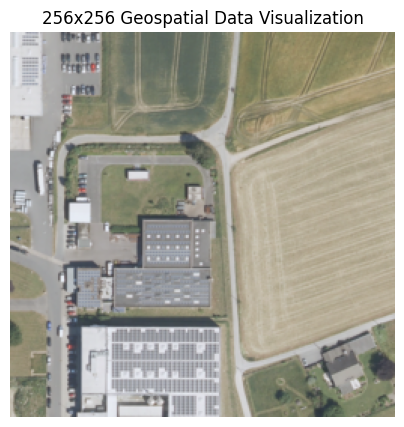

In [5]:
with rasterio.open(tile_image_paths[0]) as src:
    window = from_bounds(
        latitude_left,
        longitude_bottom,
        latitude_right,
        longitude_top,
        transform=src.transform,
    )

    partial_rgb = src.read([1, 2, 3], window=window)
    partial_rgb = np.transpose(partial_rgb, (1, 2, 0))
    partial_rgb = np.clip(partial_rgb, 0, 255).astype(np.uint8)
    pil_img = Image.fromarray(partial_rgb, mode="RGB")
    pil_img_256 = pil_img.resize((256, 256), resample=Image.BILINEAR)

    # Plot the data
    plt.figure(figsize=(5, 5))
    plt.imshow(pil_img_256)
    plt.title("256x256 Geospatial Data Visualization")
    plt.axis("off")
    plt.show()

More right than point. Is it because I didn't calculate final image bound box correct? For example, point of left bottom of this image? Anyway I will check it later.
![Image from epsg.io](./docs/screenshot-468400-5772400.png)


## Complicated case (point at the corner of jp2 image)

Now lets try to determine which image corner should I read partially and borders.  

Basically, we have all 4 points of final image format. However the question is: what would happen if I send out bbox that is out of image (will `rasterio` handle the case or raise an error?):
-  In case of error, I can calculate left, bottom, right, top of tile image to cut - open only part of it cut and continue

Let's check first!

---

Coordinate locates at the corner of 'dop10rgbi_32_468_5772_1_nw_2022' image. Should be 4 tiles that I need to concat. Expected to provide 4 tiles. 

In [6]:
latitude, longitude = 468002, 5772002

latitude_left = latitude - radius
longitude_bottom = longitude - radius
latitude_right = latitude + radius
longitude_top = longitude + radius

log.info(
    f"latitude_left {latitude_left}, longitude_bottom {longitude_bottom},\n "
    f"latitude_right {latitude_right}, longitude_top {longitude_top}"
)
tile_image_paths = get_paths_of_tile_images(
    (latitude_left, longitude_bottom, latitude_right, longitude_top),
    Path(DATASET_DIRECTORY),
)

log.info(tile_image_paths)

[2025-01-13 22:20:19,486] [INFO] latitude_left 467902, longitude_bottom 5771902,
 latitude_right 468102, longitude_top 5772102
[2025-01-13 22:20:19,487] [INFO] Found 4 tile(s) intersecting the required area.
[2025-01-13 22:20:19,488] [INFO] [PosixPath('/Users/ksafiullin/src/geospatial_data_processing/data/orthophotos/nw/dop10rgbi_32_467_5772_1_nw_2022.jp2'), PosixPath('/Users/ksafiullin/src/geospatial_data_processing/data/orthophotos/nw/dop10rgbi_32_467_5771_1_nw_2022.jp2'), PosixPath('/Users/ksafiullin/src/geospatial_data_processing/data/orthophotos/nw/dop10rgbi_32_468_5772_1_nw_2022.jp2'), PosixPath('/Users/ksafiullin/src/geospatial_data_processing/data/orthophotos/nw/dop10rgbi_32_468_5771_1_nw_2022.jp2')]


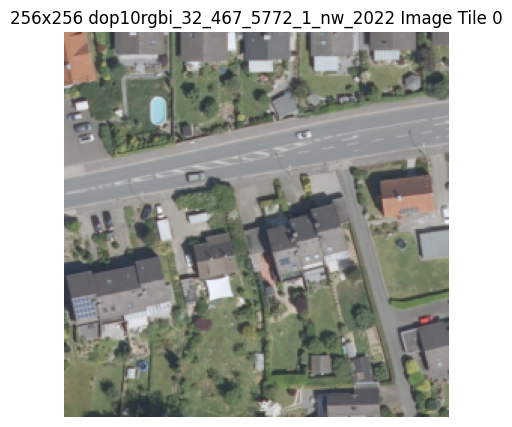

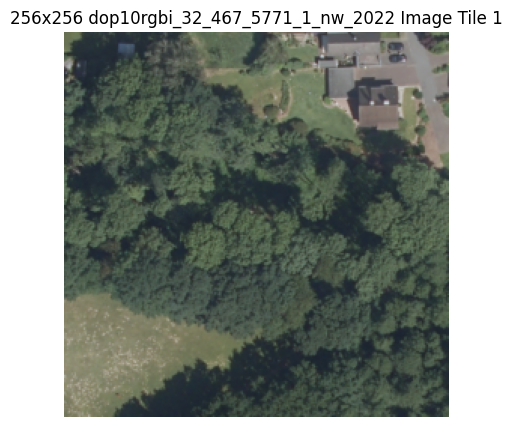

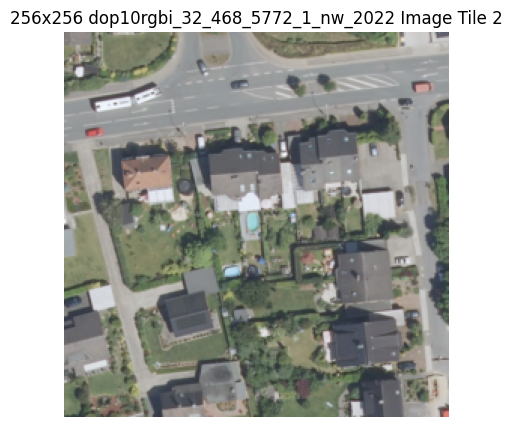

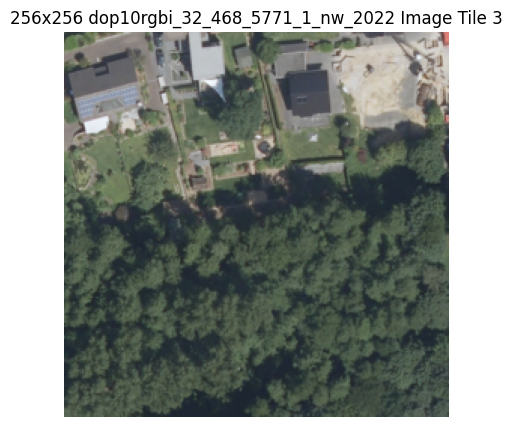

In [7]:
for iter, tile_image in enumerate(tile_image_paths):
    with rasterio.open(tile_image) as src:
        window = from_bounds(
            latitude_left,
            longitude_bottom,
            latitude_right,
            longitude_top,
            transform=src.transform,
        )

        partial_rgb = src.read([1, 2, 3], window=window)
        partial_rgb = np.transpose(partial_rgb, (1, 2, 0))
        partial_rgb = np.clip(partial_rgb, 0, 255).astype(np.uint8)
        pil_img = Image.fromarray(partial_rgb, mode="RGB")
        pil_img_256 = pil_img.resize((256, 256), resample=Image.BILINEAR)

        # Plot the data
        plt.figure(figsize=(5, 5))
        plt.imshow(pil_img_256)
        plt.title(f"256x256 {tile_image.stem} Image Tile {iter}")
        plt.axis("off")
        plt.show()

I am so confused it just shows an image without any warnings. Did it work? Did it cut as i want magically? Let go to [https://epsg.io/](https://epsg.io/map#srs=25832&x=468002&y=5772002&z=18&layer=satellite) and check this point!

Looks actually exactly as I want! 

![Image from epsg.io (/docs/screenshot-468002-5772002.png)](./docs/screenshot-468002-5772002.png)

Okay it means mist probably I don't need to cut, handle Expection, deals with numpy etc - only on final stage! Really good! Lets concat these 4 images with **right** order and check the results.

I think i don't need to create complicated logic - I will look on files names and then just send my final bound box

In [8]:
for image_path in tile_image_paths:
     log.info(image_path)

[2025-01-13 22:20:24,605] [INFO] /Users/ksafiullin/src/geospatial_data_processing/data/orthophotos/nw/dop10rgbi_32_467_5772_1_nw_2022.jp2
[2025-01-13 22:20:24,605] [INFO] /Users/ksafiullin/src/geospatial_data_processing/data/orthophotos/nw/dop10rgbi_32_467_5771_1_nw_2022.jp2
[2025-01-13 22:20:24,606] [INFO] /Users/ksafiullin/src/geospatial_data_processing/data/orthophotos/nw/dop10rgbi_32_468_5772_1_nw_2022.jp2
[2025-01-13 22:20:24,606] [INFO] /Users/ksafiullin/src/geospatial_data_processing/data/orthophotos/nw/dop10rgbi_32_468_5771_1_nw_2022.jp2


In [9]:
log.info(
    f"latitude_left {latitude_left}, longitude_bottom {longitude_bottom}, latitude_right {latitude_right}, longitude_top {longitude_top}"
)

[2025-01-13 22:20:24,611] [INFO] latitude_left 467902, longitude_bottom 5771902, latitude_right 468102, longitude_top 5772102


Desired image box:

- latitude_left: **467902** (in image close to left side)
- longitude_bottom: **5771902** (more lower/bottom)
- latitude_right: **468102** ( not in)
- longitude_top: **5772600.0** (in the middle of image)

Dataset image jp2 bbox:

- latitude_left: **467000**
- longitude_bottom: **5772000**
- latitude_right: **467999**
- longitude_top: **5772999**

So bottom right compare to this jp2 image

### Below trying to concat 2 images:

[2025-01-13 22:20:24,620] [INFO] dop10rgbi_32_467_5771_1_nw_2022.jp2
[2025-01-13 22:20:25,736] [INFO] (3, 980, 980)


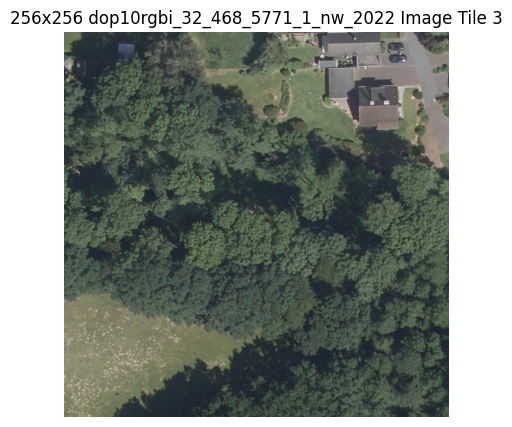

In [10]:
tile_image_paths.sort()

with rasterio.open(tile_image_paths[0]) as src:
    window_1 = from_bounds(
        latitude_left,
        longitude_bottom,
        latitude_right,
        longitude_top,
        transform=src.transform,
    )
    log.info(tile_image_paths[0].name)
    partial_rgb = src.read([1, 2, 3], window=window_1)
    log.info(partial_rgb.shape)

    partial_rgb = np.transpose(partial_rgb, (1, 2, 0))
    partial_img0 = Image.fromarray(partial_rgb, mode="RGB")
    partial_img0.resize((256, 256), Image.BILINEAR)  # type: ignore

    # Plot the data
    plt.figure(figsize=(5, 5))
    plt.imshow(partial_img0)
    plt.title(f"256x256 {tile_image.stem} Image Tile {iter}")
    plt.axis("off")
    plt.show()

[2025-01-13 22:20:25,822] [INFO] dop10rgbi_32_467_5772_1_nw_2022.jp2
[2025-01-13 22:20:28,013] [INFO] (3, 1020, 980)


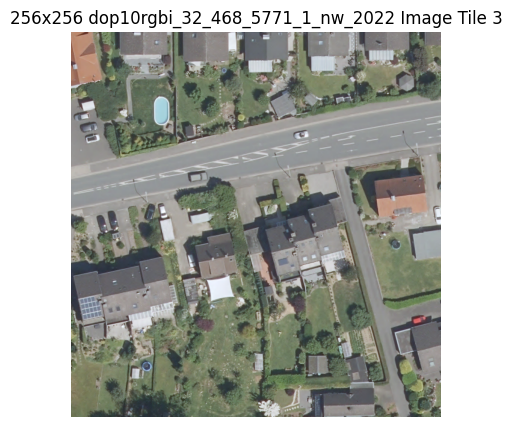

In [11]:
tile_image_paths.sort()
with rasterio.open(tile_image_paths[1]) as src:
    window_2 = from_bounds(
        latitude_left,
        longitude_bottom,
        latitude_right,
        longitude_top,
        transform=src.transform,
    )
    log.info(tile_image_paths[1].name)
    partial_rgb = src.read([1, 2, 3], window=window_2)
    log.info(partial_rgb.shape)

    partial_rgb = np.transpose(partial_rgb, (1, 2, 0))
    partial_img1 = Image.fromarray(partial_rgb, mode="RGB")
    partial_img1.resize((256, 256), Image.BILINEAR)  # type: ignore

    # Plot the data
    plt.figure(figsize=(5, 5))
    plt.imshow(partial_img1)
    plt.title(f"256x256 {tile_image.stem} Image Tile {iter}")
    plt.axis("off")
    plt.show()

This works! But i need to be careful with concatenation and order of image

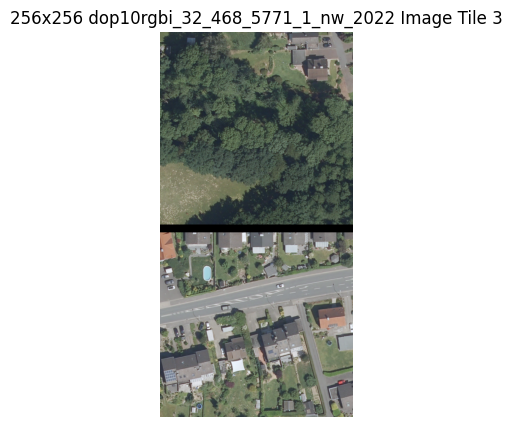

In [12]:
# concat vertical
dst = Image.new("RGB", (partial_img0.width, partial_img0.height + partial_img1.width))
dst.paste(partial_img0, (0, 0))
dst.paste(partial_img1, (0, partial_img1.height))

plt.figure(figsize=(5, 5))
plt.imshow(dst)
plt.title(f"256x256 {tile_image.stem} Image Tile {iter}")
plt.axis("off")
plt.show()

There are only 3 possible cases (if radious still not more than jp2 width, height):
- In the middle of dataset image - easy just crop
- On the border between 2 images - need to decide how to paste it (more right, top, bottom, below)
- On the corner of image - then i need to deal with 4 cut images and join them

This case becomes super complicated when there are missing images and I need to concat top left and bottom right images. Lets assume that I have everything and just concat nearest tiles. 

- In case of 1 image - return cut image
- In case of 2 image 
    - check file name if same latitude, different longitude - concat vertically
    - different latitude concat horizontally
- In case of 4 images 
    - concat 2 times horozontally first (different latitudes same differnt longitudes)
    - one time concat vertically 2 couple images

In case of radious more than 1000 - I have big problem - but this is another discussion

In [13]:
def concat_hortizontally(left_image, right_image):
    dst = Image.new("RGB", (left_image.width + right_image.width, left_image.height))
    dst.paste(left_image, (0, 0))
    dst.paste(right_image, (left_image.width, 0))
    return dst


def concat_vertically(top_image, bottom_image):
    dst = Image.new("RGB", (top_image.width, top_image.height + bottom_image.height))
    dst.paste(top_image, (0, 0))
    dst.paste(bottom_image, (0, top_image.height))
    return dst


def get_file_latitude_longitude(
    tile_image_path: pathlib.Path,
) -> Tuple[Latitude, Longitude]:
    pattern = r"dop10rgbi_32_(\d+)_(\d+)_1_nw_\d{4}\.jp2"
    match = re.match(pattern, tile_image_path.name)
    return (match.group(1), match.group(2))


def generate_tile_image(
    tile_bounding_box: Tuple[LatitudeLeft, LongitudeBottom, LatitudeRight, LatitudeTop],
    tile_image_path: pathlib.Path,
):
    log.info(f"Generating {tile_image_path.stem} tile image")
    with rasterio.open(tile_image_path) as src:
        window = from_bounds(
            *tile_bounding_box,
            transform=src.transform,
        )
        log.info(window)
        partial_rgb = src.read([1, 2, 3], window=window)
        log.info(partial_rgb.shape)

        partial_rgb = np.transpose(partial_rgb, (1, 2, 0))
        return Image.fromarray(partial_rgb, mode="RGB")


def concat_two_tile_images(
    final_image_bounding_box: Tuple[
        LatitudeLeft, LongitudeBottom, LatitudeRight, LatitudeTop
    ],
    tile_image_paths: List[pathlib.Path],
):
    first_tile_langitude, first_tile_longitude = get_file_latitude_longitude(
        tile_image_paths[0]
    )
    second_tile_langitude, second_tile_longitude = get_file_latitude_longitude(
        tile_image_paths[1]
    )

    if first_tile_langitude == second_tile_langitude:
        if first_tile_longitude < second_tile_longitude:
            return concat_vertically(
                generate_tile_image(final_image_bounding_box, tile_image_paths[0]),
                generate_tile_image(final_image_bounding_box, tile_image_paths[1]),
            )
        else:
            return concat_vertically(
                generate_tile_image(final_image_bounding_box, tile_image_paths[1]),
                generate_tile_image(final_image_bounding_box, tile_image_paths[0]),
            )
    elif first_tile_longitude == second_tile_longitude:
        if second_tile_langitude > first_tile_langitude:
            return concat_hortizontally(
                generate_tile_image(final_image_bounding_box, tile_image_paths[0]),
                generate_tile_image(final_image_bounding_box, tile_image_paths[1]),
            )
        else:
            return concat_hortizontally(
                generate_tile_image(final_image_bounding_box, tile_image_paths[1]),
                generate_tile_image(final_image_bounding_box, tile_image_paths[0]),
            )

Added dump version of checking that coordinates points out to some other place wehre is no images and generate black image. Partially black image not implemented

In [14]:
final_image_bounding_box = (
    latitude_left,
    longitude_bottom,
    latitude_right,
    longitude_top,
)

def generate_final_image(
    final_image_bounding_box: Tuple[
        LatitudeLeft, LongitudeBottom, LatitudeRight, LatitudeTop
    ],
    tile_image_paths: List[pathlib.Path],
) -> Image.Image:
    tile_image_paths.sort()  # just in case not necessary really bad - hidden affection on list

    if not tile_image_paths:
        # TODO @Karim: I need to consider case when I selected last image in dataset (e.g no image below and right).
        # So I need to create partial black image and concat with exist tiles.
        log.warning(
            "No tiles intersecting the bounding box. Returning a blank 256x256 image."
        )
        return Image.new("RGB", (256, 256), color="black")

    if len(tile_image_paths) == 1:
        return generate_tile_image(final_image_bounding_box, tile_image_paths[0])

    if len(tile_image_paths) == 2:
        return concat_two_tile_images(final_image_bounding_box, tile_image_paths)

    if len(tile_image_paths) == 4:
        _tile_image_paths = copy.deepcopy(tile_image_paths)
        return concat_vertically(
            concat_two_tile_images(
                final_image_bounding_box, [_tile_image_paths[1], _tile_image_paths[3]]
            ),
            concat_two_tile_images(
                final_image_bounding_box, [_tile_image_paths[0], _tile_image_paths[2]]
            ),
        )
    else:
        error_message = "I didn't implement other cases with missing images in dataset. Only when there is no found tile images at all"
        log.error(error_message)
        raise NotImplementedError(error_message)

Case when it's on the corner of 4 til images

[2025-01-13 22:20:28,199] [INFO] Generating dop10rgbi_32_467_5772_1_nw_2022 tile image
[2025-01-13 22:20:28,202] [INFO] Window(col_off=np.float64(9020.0), row_off=np.float64(8980.0), width=np.float64(2000.0), height=np.float64(2000.0))
[2025-01-13 22:20:30,429] [INFO] (3, 1020, 980)
[2025-01-13 22:20:30,442] [INFO] Generating dop10rgbi_32_468_5772_1_nw_2022 tile image
[2025-01-13 22:20:30,446] [INFO] Window(col_off=np.float64(-980.0), row_off=np.float64(8980.0), width=np.float64(2000.0), height=np.float64(2000.0))
[2025-01-13 22:20:31,473] [INFO] (3, 1020, 1020)
[2025-01-13 22:20:31,496] [INFO] Generating dop10rgbi_32_467_5771_1_nw_2022 tile image
[2025-01-13 22:20:31,521] [INFO] Window(col_off=np.float64(9020.0), row_off=np.float64(-1020.0), width=np.float64(2000.0), height=np.float64(2000.0))
[2025-01-13 22:20:32,653] [INFO] (3, 980, 980)
[2025-01-13 22:20:32,665] [INFO] Generating dop10rgbi_32_468_5771_1_nw_2022 tile image
[2025-01-13 22:20:32,668] [INFO] Window(col_off=np.float64(-

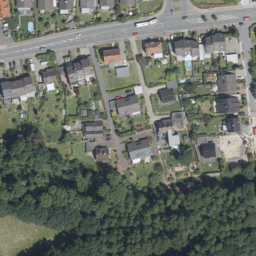

In [15]:
image = generate_final_image(final_image_bounding_box, tile_image_paths)
image.resize((256, 256), Image.BILINEAR)

# Conclusion 

Basically now I can concat images and will finish main logic of the project and clean project style. I only need to run whole pipeline with different case 1,2,4 tiles and show the results. I will finish it in `main.py`